In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
#
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [2]:
ds_train = datasets.MNIST(root='./data', train=True, download=True, transform=T.ToTensor())
ds_valid = datasets.MNIST(root="./data", train=False, download=True, transform=T.ToTensor())

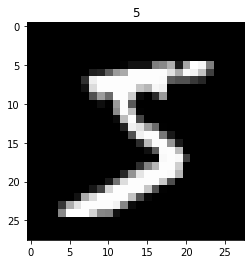

In [3]:
plt.imshow(ds_train.data[0], cmap='gray')
plt.title('%i' % ds_train.targets[0])
plt.show()

In [4]:
dl_train = torch.utils.data.DataLoader(ds_train, 
                                          batch_size=256, 
                                          shuffle=True, 
                                          num_workers=4)
dl_valid = torch.utils.data.DataLoader(ds_valid, 
                                          batch_size=16, 
                                          shuffle=True, 
                                          num_workers=4)

# Baseline CNN for MNIST

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output    # return x for visualization

In [6]:
model = CNN()

In [7]:
loss_func = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr = 0.01) 

In [ ]:
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    for idx, (x, y_true) in enumerate(dl_train):
        y_pred = model(x)
        loss = loss_func(y_pred, y_true)

        # clear gradients for this training step   
        optimizer.zero_grad()           
            
        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()
        
        if idx % 1000 == 0:
            print("Epoch[{}/{}] - step {} loss: {:.4f}".format(epoch, num_epochs, idx, loss.item()))

C:\Users\mkoch\anaconda3\envs\EfficientCN\lib\site-packages\torch\autograd\__init__.py:154: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


Epoch[0/10] - step 0 loss: 2.3075


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for x, y_true in dl_valid:
        y_pred = model(x)
        y_pred = torch.max(y_pred, 1)[1]
        correct += (y_pred == y_true).sum().item()
        total += y_true.shape[0]
    acc = correct / total

In [ ]:
print(acc)
print(total - correct)

# Eff-Caps

In [ ]:
class PrimaryCaps(nn.Module):
    """
        Create a primary capsule layer with the methodology described in 'Efficient-CapsNet: Capsule Network with Self-Attention Routing'. 
        Properties of each capsule s_n are exatracted using a 2D depthwise convolution.

        ...

        Attributes
        ----------
        F: int depthwise conv number of features
        K: int depthwise conv kernel dimension 
        N: int number of primary capsules
        D: int primary capsules dimension (number of properties)
        s: int depthwise conv strides
    """
    def __init__(self, F, K, N, D, s=1):
        super().__init__()
        self.F = F
        self.K = K
        self.N = N
        self.D = D
        self.s = s
        #
        self.dw_conv2d = nn.Conv2d(F, F, kernel_size=K, stride=s, groups=F, padding="valid")
        #
    def forward(self, x):
        """
         X in (B,C,H,W) = (B,F,K,K)
         -> (B, N, D)
        """
        # (B,C,H,W) -> (B,C,H,W)
        x = self.dw_conv2d(x)

        # (B,C,H,W) -> (B, N, D)
        x = x.view((-1, self.N, self.D))
        
        #
        return x

class Squash(nn.Module):
    def __init__(self, eps=10e-21):
        super().__init__()
        self.eps = eps
    def forward(self, x):
        raise NotImplementedError()

class FCCaps(nn.Module):
    def __init__(self):
        super().__init__()
    def forware(self, x):
        raise NoteImplementedError()

class EfficientCapsNets(nn.Module):
    def __init__(self):
        super().__init__()
    def call(self, x):
        pass

In [ ]:
# CNN Part
# add he normal initializer
cn = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=(5, 5), padding="valid"),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=(3, 3), padding="valid"),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=(3, 3), padding="valid"),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=(3, 3), stride=2, padding="valid"),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(128),
)
x_h = cn(x)
print(x_h.shape)

In [ ]:
pc = PrimaryCaps(F=128, K=9, N=16, D=8)
#
z = pc(x_h)
print(z.shape)

In [ ]:
x = x.view((-1, 16, 8))

In [ ]:
z.view((-1, 16, 8))

In [ ]:
n, d = 4, 3
eps = 10e-21
s = torch.rand((n, d))
s_norm = torch.linalg.vector_norm(s, dim=1)
#
print(s.shape)
print(s_norm.shape)

# TensorFlow Stuff

In [ ]:
class Squash(tf.keras.layers.Layer):
    """
    Squash activation used in 'Efficient-CapsNet: Capsule Network with Self-Attention Routing'.
    
    ...
    
    Attributes
    ----------
    eps: int
        fuzz factor used in numeric expression
    
    Methods
    -------
    call(s)
        compute the activation from input capsules
    """

    def __init__(self, eps=10e-21, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def call(self, s):
        n = tf.norm(s,axis=-1,keepdims=True)
        return (1 - 1/(tf.math.exp(n)+self.eps))*(s/(n+self.eps))

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
class PrimaryCaps(tf.keras.layers.Layer):
    """
    Create a primary capsule layer with the methodology described in 'Efficient-CapsNet: Capsule Network with Self-Attention Routing'. 
    Properties of each capsule s_n are exatracted using a 2D depthwise convolution.
    
    ...
    
    Attributes
    ----------
    F: int
        depthwise conv number of features
    K: int
        depthwise conv kernel dimension
    N: int
        number of primary capsules
    D: int
        primary capsules dimension (number of properties)
    s: int
        depthwise conv strides
    Methods
    -------
    call(inputs)
        compute the primary capsule layer
    """
    def __init__(self, F, K, N, D, s=1, **kwargs):
        super(PrimaryCaps, self).__init__(**kwargs)
        self.F = F
        self.K = K
        self.N = N
        self.D = D
        self.s = s
        
    def build(self, input_shape):    
        self.DW_Conv2D = tf.keras.layers.Conv2D(self.F, self.K, self.s,
                                             activation='linear', groups=self.F, padding='valid')

        self.built = True
    
    def call(self, inputs):      
        x = self.DW_Conv2D(inputs)      
        x = tf.keras.layers.Reshape((self.N, self.D))(x)
        x = Squash()(x)
        
        return x

In [ ]:
class FCCaps(tf.keras.layers.Layer):
    """
    Fully-connected caps layer. It exploites the routing mechanism, explained in 'Efficient-CapsNet: Capsule Network with Self-Attention Routing', 
    to create a parent layer of capsules. 
    
    ...
    
    Attributes
    ----------
    N: int
        number of primary capsules
    D: int
        primary capsules dimension (number of properties)
    kernel_initilizer: str
        matrix W initialization strategy
 
    Methods
    -------
    call(inputs)
        compute the primary capsule layer
    """
    def __init__(self, N, D, kernel_initializer='he_normal', **kwargs):
        super(FCCaps, self).__init__(**kwargs)
        self.N = N
        self.D = D
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        
    def build(self, input_shape):
        input_N = input_shape[-2]
        input_D = input_shape[-1]

        self.W = self.add_weight(shape=[self.N, input_N, input_D, self.D],initializer=self.kernel_initializer,name='W')
        self.b = self.add_weight(shape=[self.N, input_N,1], initializer=tf.zeros_initializer(), name='b')
        self.built = True
    
    def call(self, inputs, training=None):
        
        # j=n
        # i=d
        # k=n
        # z=d
        # inputs(n, d)
        # W(n,n,d,d)
        # u(n,n,d)
        u = tf.einsum('...ji,kjiz->...kjz',inputs,self.W)         # u shape=(None,N,H*W*input_N,D)
             
        c = tf.einsum('...ij,...kj->...i', u, u)[...,None]        # b shape=(None,N,H*W*input_N,1) -> (None,j,i,1)
        c = c/tf.sqrt(tf.cast(self.D, tf.float32))
        c = tf.nn.softmax(c, axis=1)                              # c shape=(None,N,H*W*input_N,1) -> (None,j,i,1)
        c = c + self.b
        s = tf.reduce_sum(tf.multiply(u, c),axis=-2)             # s shape=(None,N,D)
        v = Squash()(s)       # v shape=(None,N,D)
        
        return v

    def compute_output_shape(self, input_shape):
        return (None, self.C, self.L)

    def get_config(self):
        config = {
            'N': self.N,
            'D': self.D
        }
        base_config = super(FCCaps, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



class Length(tf.keras.layers.Layer):
    """
    Compute the length of each capsule n of a layer l.
    ...
    
    Methods
    -------
    call(inputs)
        compute the length of each capsule
    """

    def call(self, inputs, **kwargs):
        """
        Compute the length of each capsule
        
        Parameters
        ----------
        inputs: tensor
           tensor with shape [None, num_capsules (N), dim_capsules (D)]
        """
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), - 1) + tf.keras.backend.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config

class Mask(tf.keras.layers.Layer):
    """
    Mask operation described in 'Dynamic routinig between capsules'.
    
    ...
    
    Methods
    -------
    call(inputs, double_mask)
        mask a capsule layer
        set double_mask for multimnist dataset
    """
    def call(self, inputs, double_mask=None, **kwargs):
        if type(inputs) is list:
            if double_mask:
                inputs, mask1, mask2 = inputs
            else:
                inputs, mask = inputs
        else:  
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            if double_mask:
                mask1 = tf.keras.backend.one_hot(tf.argsort(x,direction='DESCENDING',axis=-1)[...,0],num_classes=x.get_shape().as_list()[1])
                mask2 = tf.keras.backend.one_hot(tf.argsort(x,direction='DESCENDING',axis=-1)[...,1],num_classes=x.get_shape().as_list()[1])
            else:
                mask = tf.keras.backend.one_hot(indices=tf.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        if double_mask:
            masked1 = tf.keras.backend.batch_flatten(inputs * tf.expand_dims(mask1, -1))
            masked2 = tf.keras.backend.batch_flatten(inputs * tf.expand_dims(mask2, -1))
            return masked1, masked2
        else:
            masked = tf.keras.backend.batch_flatten(inputs * tf.expand_dims(mask, -1))
            return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # generation step
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config

# Pytorch implementation

# Squashing

In [50]:
def squash_fun(x,eps=10e-21):
    """
    Input:
        x(b,n,d)
    Output:
        y = squash(x(b,n,d))
    """
    
    x_norm = torch.norm(x, dim=-1, keepdim=True)
    y = (1 - 1/torch.exp(x_norm) + eps) * (x/x_norm + eps)
    
    return y

In [51]:
print(squash_fun(U_h))
print(squash_fun(torch.tensor([[1., 2., 1.], [-1., 2., -3.], [0.,1.,-2.]])))

NameError: name 'U_h' is not defined

In [52]:
class Squash(nn.Module):
    def __init__(self,eps=10e-21):
        super().__init__()
        self.eps = eps
        
    def forward(self,x):
        """
        Input:  x(b,n,d)
        Output: squash(x(b,n,d))
        """        
        return squash_fun(x,self.eps)

In [53]:
A = Squash()

print(A.forward(U_h))
print(A(U_h))

NameError: name 'U_h' is not defined

# FC Caps + Self Attention Routing

In [68]:
class FCCaps(nn.Module):
    """
    Fully-connected caps layer. It exploites the routing mechanism, explained in 'Efficient-CapsNet: Capsule Network with Self-Attention Routing', 
    to create a parent layer of capsules. 
    
    nl: number of input capsuls          (nl...i)(nl...h)
    dl: dimension of input capsuls       (dl...j)
    nh: number of output capsuls         (nh...k)
    dh: dimension of output capsuls      (dh...l)
    b: batch size                        (...)

    W: weigth tensor                     (W->ikjl)
    B: bias matrix                       (B->ik1)
    U_l: input capsuls matrix            (U->...ij)    
    U_hat: weigthed input capsuls matrix (U_hat->...ikl)
    A: covariance tensor                 (A->...hik)
    C: couplimg coefficients             (C->...ik)
    
    input: nl, dl, nh, dh
    
    """
    
    def __init__(self, nl, dl, nh, dh):
        super().__init__()
        self.nl = nl
        self.dl = dl
        self.nh = nh
        self.dh = dh

        self.W = torch.rand([self.nl,self.nh,self.dl,self.dh])
        self.B = torch.rand([1,self.nl,self.nh])
        
        self.squash = Squash()
                
        
    def forward(self, U_l):
        U_hat = torch.einsum("...ij,ikjl->...ikl",U_l,self.W)
        A = torch.einsum("...hkl,...ikl->...hik",U_hat, U_hat)
        A = A / torch.sqrt(torch.Tensor([self.dl]))
        A_hat = torch.einsum("...hik->...ik",A)
        C = torch.softmax(A_hat,dim=-1)
        CB = C+self.B
        U_h = torch.einsum("...ikl,...ik->...kl",U_hat,CB)
        U_h = self.squash(U_h)
        return U_h
        
        

In [69]:
torch.manual_seed(0)
input_dim = (2,3,4)
U_l = torch.rand(size=input_dim)
A = FCCaps(3,4,2,5)
U_h = A.forward(U_l)

print(U_l)
print(U_h)
print(U_h.size())
print(A.nl,A.nh,A.dl, A.dh)

#print(A.U_hat.size())
#print(A.b)

tensor([[[0.4963, 0.7682, 0.0885, 0.1320],
         [0.3074, 0.6341, 0.4901, 0.8964],
         [0.4556, 0.6323, 0.3489, 0.4017]],

        [[0.0223, 0.1689, 0.2939, 0.5185],
         [0.6977, 0.8000, 0.1610, 0.2823],
         [0.6816, 0.9152, 0.3971, 0.8742]]])
tensor([[[0.5000, 0.2828, 0.5209, 0.4214, 0.4531],
         [0.2448, 0.4859, 0.6130, 0.4353, 0.3700]],

        [[0.5355, 0.2815, 0.4004, 0.3977, 0.5589],
         [0.3317, 0.4814, 0.5511, 0.3910, 0.4369]]])
torch.Size([2, 2, 5])
3 2 4 5


In [ ]:
assert 4==4

# PrimaryCaps

In [ ]:
class PrimaryCaps(nn.Module):
    """
        Create a primary capsule layer with the methodology described in 'Efficient-CapsNet: Capsule Network with Self-Attention Routing'. 
        Properties of each capsule s_n are exatracted using a 2D depthwise convolution.

        ...

        Attributes
        ----------
        F: int depthwise conv number of features
        K: int depthwise conv kernel dimension 
        N: int number of primary capsules
        D: int primary capsules dimension (number of properties)
        s: int depthwise conv strides
    """
    def __init__(self, F, K, N, D, s=1):
        super().__init__()
        self.F = F
        self.K = K
        self.N = N
        self.D = D
        self.s = s
        #
        self.dw_conv2d = nn.Conv2d(F, F, kernel_size=K, stride=s, groups=F, padding="valid")
        self.squash = Squash()
        #
    def forward(self, x):
        """
         X in (B,C,H,W) = (B,F,K,K)
         -> (B, N, D)
        """
        # (B,C,H,W) -> (B,C,H,W)
        x = self.dw_conv2d(x)
        # (B,C,H,W) -> (B, N, D)
        x = x.view((-1, self.N, self.D))
        x = self.squash(x)
        #
        return x

In [ ]:
B = PrimaryCaps(10,3,4,5)
x = torch.rand((8,10,8,8))
B(x).size()

In [ ]:
print(10*8*6*6)
print(144*4*5)

# Margin Loss

In [5]:
import tensorflow as tf

In [17]:
def marginLoss(y_true, y_pred):
    lbd = 0.5
    m_plus = 0.9
    m_minus = 0.1
    
    L = y_true * tf.square(tf.maximum(0., m_plus - y_pred)) +  lbd * (1 - y_true) * tf.square(tf.maximum(0., y_pred - m_minus))

    return tf.reduce_mean(tf.reduce_sum(L, axis=1))

In [19]:
y_true = tf.constant([1,1])

u = tf.constant(([[[0.4963, 0.7682, 0.0885, 0.1320, 0.3074],
                   [0.6341, 0.4901, 0.8964, 0.4556, 0.6323]],
                  [[0.3489, 0.4017, 0.0223, 0.1689, 0.2939],
                   [0.5185, 0.6977, 0.8000, 0.1610, 0.2823]]]))
print(u)
u = tf.reduce_sum(u, axis=1)


print(u)
#marginLoss(y_true,u)

tf.Tensor(
[[[0.4963 0.7682 0.0885 0.132  0.3074]
  [0.6341 0.4901 0.8964 0.4556 0.6323]]

 [[0.3489 0.4017 0.0223 0.1689 0.2939]
  [0.5185 0.6977 0.8    0.161  0.2823]]], shape=(2, 2, 5), dtype=float32)
tf.Tensor(
[[1.1304001  1.2583     0.9849     0.5876     0.9397    ]
 [0.86739993 1.0994     0.8223     0.3299     0.5762    ]], shape=(2, 5), dtype=float32)


In [27]:
def margin_loss(u, y_true, lbd=0.5, m_plus=0.9, m_minus=0.1):
    """
    Input:  u      (b,n,d)  ... capsules with n equals the numbe of classes
            y_true (b,n)    ... labels vector, categorical representation
    Output:
        loss, scalar  
    """
    
    u_norm = torch.norm(u, dim=-1)
    p_true = torch.square(F.relu(m_plus - u_norm))
    p_false = torch.square(F.relu(u_norm - m_minus))

    loss = y_true * p_true + lbd * (1-y_true) * p_false
    loss = loss.sum(dim=1).mean()
    
    return loss

In [28]:
torch.manual_seed(0)
y_true = torch.tensor([0,1])
u = torch.rand((1,2,5))
print(u)
margin_loss(u, y_true)

tensor([[[0.4963, 0.7682, 0.0885, 0.1320, 0.3074],
         [0.6341, 0.4901, 0.8964, 0.4556, 0.6323]]])


tensor(0.3853)

In [29]:
def margin_lossM(u, y_true, lbd=0.5, m_plus=0.9, m_minus=0.1):
    """
    IN:
        u      (b,n,d)  ... capsules with n equals the numbe of classes
        y_true (b,n)    .... labels vector, categorical representation
    OUT:
        loss, scalar  
    """
    u_norm = torch.norm(u, dim=2)
    
    print(u_norm)
    term_left  = F.relu(m_plus - u_norm)
    print(term_left)
    term_right = F.relu(u_norm - m_minus)
    #
    loss = y_true * term_left + lbd * (1.0 - y_true) * term_right
    print(loss)
    loss = loss.sum(dim=1).mean()
    print(loss)
    return loss

In [31]:
torch.manual_seed(0)
y_true = torch.tensor([0,1])
u = torch.rand((1,2,5))
print(u)
margin_lossM(u, y_true)

tensor([[[0.4963, 0.7682, 0.0885, 0.1320, 0.3074],
         [0.6341, 0.4901, 0.8964, 0.4556, 0.6323]]])
tensor([[0.9779, 1.4329]])
tensor([[0., 0.]])
tensor([[0.4389, 0.0000]])
tensor(0.4389)


tensor(0.4389)

# masked reconstruction loss

In [45]:
def max_norm_masking(u):
    """
     Input: u (b, n, d)
     normalise over dimension d
     keep largest vector in dimension n
     mask out everything else
     Output: u_mask (b, n, d)
    """
    _, n_classes, _ = u.shape
    u_norm = torch.norm(u,dim=2)
    mask = F.one_hot(torch.argmax(u_norm,1), num_classes=n_classes)
    u_mask = torch.einsum('bnd,bn->bnd',u, mask)
    return u_mask

In [47]:
torch.manual_seed(0)
u = torch.rand((3,5,5))
print(u)
a = max_norm_masking(u)
print(a)

tensor([[[0.4963, 0.7682, 0.0885, 0.1320, 0.3074],
         [0.6341, 0.4901, 0.8964, 0.4556, 0.6323],
         [0.3489, 0.4017, 0.0223, 0.1689, 0.2939],
         [0.5185, 0.6977, 0.8000, 0.1610, 0.2823],
         [0.6816, 0.9152, 0.3971, 0.8742, 0.4194]],

        [[0.5529, 0.9527, 0.0362, 0.1852, 0.3734],
         [0.3051, 0.9320, 0.1759, 0.2698, 0.1507],
         [0.0317, 0.2081, 0.9298, 0.7231, 0.7423],
         [0.5263, 0.2437, 0.5846, 0.0332, 0.1387],
         [0.2422, 0.8155, 0.7932, 0.2783, 0.4820]],

        [[0.8198, 0.9971, 0.6984, 0.5675, 0.8352],
         [0.2056, 0.5932, 0.1123, 0.1535, 0.2417],
         [0.7262, 0.7011, 0.2038, 0.6511, 0.7745],
         [0.4369, 0.5191, 0.6159, 0.8102, 0.9801],
         [0.1147, 0.3168, 0.6965, 0.9143, 0.9351]]])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.6816, 0.9152,